In [1]:
%pip install scikit-learn
%pip install TensorFlow
%pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/4e/ba/ce9bd1cd4953336a0e213b29cb80bb11816f2a93de8c99f88ef0b446ad0c/scikit_learn-1.3.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for scipy>=1.5.0 from https://files.pythonhosted.org/packages/43/d0/f3cd75b62e1b90f48dbf091261b2fc7ceec14a700e308c50f6a69c83d337/scipy-1.11.4-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------------------------- ------------ 41.0/60.4 kB 991.0 kB/s eta 0:00:01
     ---------------------------------------- 60.4/60.4 kB 1.1 MB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Obtaining dependency information for threadpoolctl>=2.0.0 from https


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
from pathlib import Path
from tensorflow.keras import datasets, layers, models
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
TensorFlow version: 2.15.0


In [11]:
import tensorflow as tf
if tf.test.gpu_device_name():
   print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

DEVICE = "/physical_device:GPU:0"

Please install GPU version of TF


In [46]:

current_dir = os.getcwd()
dataset_folder = 'Train'
dataset_path = Path(current_dir) / dataset_folder
file_list = os.listdir(dataset_path)

valid_folder = 'Valid'

valid_path = Path(current_dir) / valid_folder
valid_list = os.listdir(valid_path)

print("The training directory: ", file_list)
print("The validation directory: ", valid_list)


The training directory:  ['.DS_Store', 'Squires', 'Gables', 'UCB']
The validation directory:  ['.DS_Store', 'Squires', 'Gables', 'UCB_V']


In [47]:
batch_size = 32
img_height = 256
img_width = 256

In [49]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(dataset_path,
                                                   target_size=(img_width, img_height),
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 737 images belonging to 3 classes.


In [50]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(valid_path,
                                                             target_size=(img_width, img_height),
                                                             batch_size=batch_size,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 359 images belonging to 3 classes.


In [51]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Gables
1 : Squires
2 : UCB


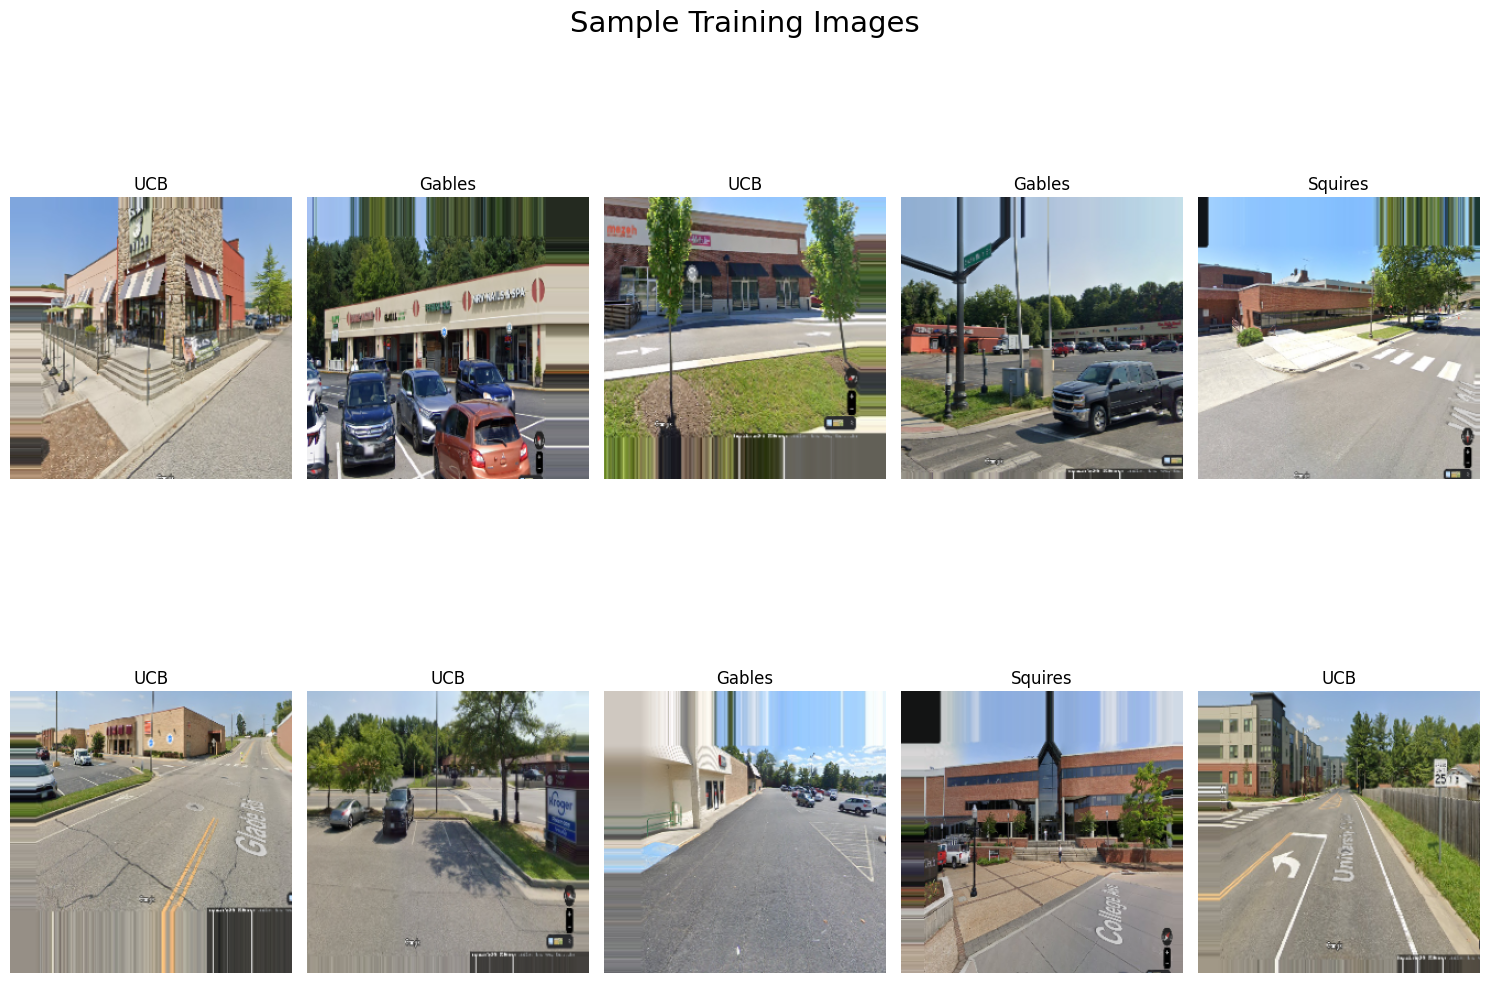

In [52]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [58]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256,256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,(5,5),activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


In [59]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
# Reduces learning rate when it plateus 

In [60]:
optimizer = Adam(learning_rate=0.001)

In [61]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 123, 123, 64)      51264     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 61, 61, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 238144)            0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [64]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/10


2023-11-25 21:59:05.323050: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: OSError: image file is truncated
Traceback (most recent call last):

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/ImageFile.py", line 249, in load
    s = read(self.decodermaxblock)

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/PngImagePlugin.py", line 929, in load_read
    cid, pos, length = self.png.read()

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/PngImagePlugin.py", line 166, in read
    length = i32(s)

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/_binary.py", line 85, in i32be
    return unpack_from(">I", c, o)[0]

struct.error: unpack_from requires a buffer of at least 4 bytes for unpacking 4 bytes at offset 0 (actual buffer size is 0)


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/Users/sathya/Library/Python/3.9/lib/python/s

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  OSError: image file is truncated
Traceback (most recent call last):

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/ImageFile.py", line 249, in load
    s = read(self.decodermaxblock)

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/PngImagePlugin.py", line 929, in load_read
    cid, pos, length = self.png.read()

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/PngImagePlugin.py", line 166, in read
    length = i32(s)

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/_binary.py", line 85, in i32be
    return unpack_from(">I", c, o)[0]

struct.error: unpack_from requires a buffer of at least 4 bytes for unpacking 4 bytes at offset 0 (actual buffer size is 0)


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/keras/src/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/keras/src/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/keras/src/utils/image_utils.py", line 439, in load_img
    img = img.convert("RGB")

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/Image.py", line 916, in convert
    self.load()

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/ImageFile.py", line 256, in load
    raise OSError(msg) from e

OSError: image file is truncated


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_16]]
  (1) UNKNOWN:  OSError: image file is truncated
Traceback (most recent call last):

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/ImageFile.py", line 249, in load
    s = read(self.decodermaxblock)

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/PngImagePlugin.py", line 929, in load_read
    cid, pos, length = self.png.read()

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/PngImagePlugin.py", line 166, in read
    length = i32(s)

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/_binary.py", line 85, in i32be
    return unpack_from(">I", c, o)[0]

struct.error: unpack_from requires a buffer of at least 4 bytes for unpacking 4 bytes at offset 0 (actual buffer size is 0)


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/keras/src/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/keras/src/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/keras/src/utils/image_utils.py", line 439, in load_img
    img = img.convert("RGB")

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/Image.py", line 916, in convert
    self.load()

  File "/Users/sathya/Library/Python/3.9/lib/python/site-packages/PIL/ImageFile.py", line 256, in load
    raise OSError(msg) from e

OSError: image file is truncated


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_5769]